In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib import cm
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Normalization
from keras.models import Sequential
from keras.activations import sigmoid
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2026-01-06 14:59:00.006086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 1234
keras.utils.set_random_seed(
    SEED
)  # controlled randomness for learning, not absolute determinism

In [3]:
def load_coffee_data():
    """Creates a coffee roasting data set.
    roasting duration: 12-15 minutes is best
    temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5  # 12-15 min is best. [0, 1) -> [0, 4) -> [11.5, 15.5)
    X[:, 0] = (
        X[:, 0] * (285 - 150) + 150
    )  # 350-500 F (175-260 C) is best [0, 1) -> [0, 135) -> [150, 285)
    Y = np.zeros(len(X))

    i = 0
    for t, d in X:
        y = -3 / (260 - 175) * t + 21
        if (
            t > 175 and t < 260 and d > 12 and d < 15 and d <= y
        ):  # d <= y is for the area under the slanted line, not the whole rectangle
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    return (X, Y.reshape(-1, 1))

In [4]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [5]:
def plt_roast(X, Y):
    Y = Y.reshape(
        -1,
    )
    colormap = np.array(["r", "b"])
    pos = Y == 1
    neg = ~pos
    fig, ax = plt.subplots(1, 1)
    ax.scatter(X[pos, 0], X[pos, 1], s=70, marker="x", c="r", label="Good Roast")
    ax.scatter(
        X[neg, 0],
        X[neg, 1],
        s=90,
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        label="Bad Roast",
    )
    tr = np.linspace(175, 260, 50)
    ax.plot(tr, -3 / 85 * tr + 21, c="purple", lw=1)
    ax.axhline(y=12, c="purple", lw=1)
    ax.axvline(x=175, c="purple", lw=1)
    ax.set_title("Coffee Roasting")
    ax.set_ylabel("Duration \n(minutes)")
    ax.set_xlabel("Temperature \n(Celsius)")
    ax.legend(loc="upper right")
    plt.show()

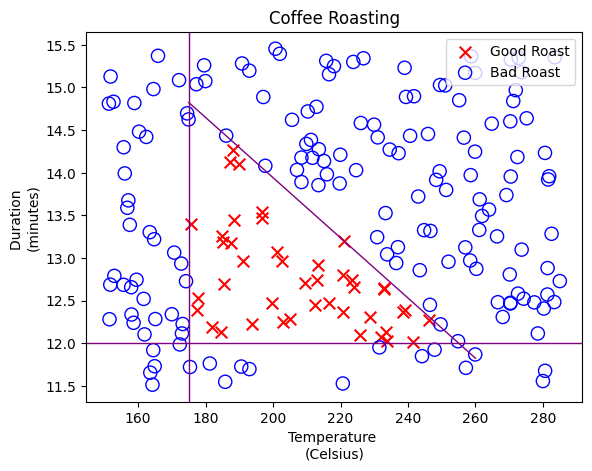

In [6]:
plt_roast(X, Y)

In [7]:
# tf.random.set_seed(1234)  # we are seeding keras as our single source of truth for reprodicible results
print(
    f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}"
)
print(
    f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}"
)
normalizer = keras.layers.Normalization(
    axis=-1, name="input_normalizer"
)  # normalize each feature independently
normalizer.adapt(X)  # learns mean, variance
Xn = normalizer(
    X
)  # only for seeing the min, max values. Not used further. Integrating the Normalization layer in the model keeps the architecture explicit.
print(
    f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}"
)
print(
    f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}"
)

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [8]:
# NOTE:
# We tile (replicate) the dataset to artificially increase the number of samples so that
# gradient-based training is visually and numerically stable in this small teaching lab.
# This does NOT add new information and increases sample correlation.
#
# This is NOT recommended in production:
# - It inflates the dataset without improving generalization
# - It can bias optimization dynamics
# - It gives a false sense of data volume
#
# In production, we would instead:
# - Collect more real data, or
# - Use data augmentation (domain-appropriate), or
# - Adjust training strategy (batch size, epochs, regularization),
# - Or accept small-data regimes and use simpler / regularized models.
Xt = np.tile(X, (1000, 1))
Yt = np.tile(Y, (1000, 1))
print(Xt.shape, Yt.shape)

(200000, 2) (200000, 1)


In [9]:
# NOTE on sigmoid in the final layer:
# Adding a sigmoid activation in the output layer is convenient for teaching and visualization,
# but it is NOT recommended in production training code.
#
# Why:
# - Applying sigmoid here forces probabilities to be computed inside the model
# - This can cause numerical instability for large positive/negative logits
# - Gradients can saturate, slowing or destabilizing training
#
# Production best practice:
# - Output raw logits (no sigmoid in the final layer)
#
#     Dense(1, activation="linear", name="layer2"), or Dense(1, name="layer2")
#
# - Compute the loss from logits using a numerically stable formulation:
#
#     loss = -y*z + max(0, z) + log(1 + exp(-|z|))
#
#   where z is the raw model output (logit) and y ∈ {0,1}
#
# In Keras, this means:
# - Remove sigmoid from the final Dense layer
# - Use BinaryCrossentropy(from_logits=True)
#
# We keep sigmoid here only because this is a small teaching lab focused on intuition,
# not large-scale or numerically sensitive training.

model = Sequential(
    [
        Input(shape=(2,), name="input_features"),
        normalizer,
        Dense(3, activation="sigmoid", name="layer1"),
        Dense(1, activation="sigmoid", name="layer2"),
    ]
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_normalizer                │ (None, 2)              │             5 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18 (76.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 5 (24.00 B)

In [11]:
L1_num_params = 2 * 3 + 3  # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1  # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params)

L1 params =  9 , L2 params =  4


In [12]:
# The model has enough shape information to build the graph eagerly and initialize the weights immediately.
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:\n", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:\n", b2)

W1(2, 3):
 [[ 0.22066653  0.7737359   0.07901227]
 [-0.78397894  0.11129558  0.8685827 ]] 
b1(3,):
 [0. 0. 0.]
W2(3, 1):
 [[1.03328   ]
 [0.6218219 ]
 [0.43558836]] 
b2(1,):
 [0.]


In [15]:
# NOTE on BinaryCrossentropy without logits:
# We are using the default BinaryCrossentropy() with the final layer already applying sigmoid.
# This is fine for teaching and visualization purposes, but it is NOT recommended in production training.
#
# Why this is suboptimal:
# - Numerical instability: computing sigmoid first can cause overflow/underflow for large logits
# - Gradients can saturate for extreme values, slowing or destabilizing learning
# - Less precise for very small or very large probability predictions
#
# Production best practice:
# - Remove the sigmoid from the final Dense layer (output raw logits)
# - Use BinaryCrossentropy(from_logits=True) so Keras applies a **numerically stable** combination
#   of sigmoid + cross-entropy internally:
#       loss = -y*z + max(0, z) + log(1 + exp(-|z|))
# - This keeps training stable even with extreme logits
#
# We keep the sigmoid and default BinaryCrossentropy here only because this is a small teaching lab
# with a tiny, synthetic dataset and the main goal is intuition, not large-scale stability.

model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
)
model.fit(
    Xt,
    Yt,
    epochs=10,
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2485
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.1191
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.1033
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0241
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0138
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0095
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0068
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0049
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0036
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0027


In [16]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:\n", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:\n", b2)

W1(2, 3):
 [[12.332719    0.03043381 15.113347  ]
 [ 0.2751422  -9.228262   12.63826   ]] 
b1(3,):
 [ 12.903088  -11.54752     1.9974849]
W2(3, 1):
 [[ 38.197327]
 [-44.429035]
 [-40.5508  ]] 
b2(1,):
 [-12.367384]


In [17]:
# NOTE:
# Normalization is part of the model, so we can feed raw input X_test.
# Predictions reflect the model’s learned decision boundary, even though weights are large.
#
# Things to remember for production:
# - Never normalize outside the model if the Normalization layer is included
# - Always feed raw features; the model handles scaling internally
# - The threshold of 0.5 is appropriate for sigmoid outputs; for logits, we'd need to apply sigmoid first

X_test = np.array([[200, 13.9], [200, 17]])
# X_testn = normalizer(X_test) # not needed because the normalizer is a part of the model
# predictions = model.predict(X_testn)  # not needed because the normalizer is a part of the model
predictions = model.predict(X_test)
print("Predictions = \n", predictions)
# print([f"{arr[0]:0.4f}" for arr in predictions])
# predictions_binary = [[1] if arr >= 0.5 else [0] for arr in predictions]
# print(predictions_binary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Predictions = 
 [[9.7261649e-01]
 [3.9931658e-07]]


In [18]:
# The threshold of 0.5 is appropriate for sigmoid outputs; for logits, we'd need to apply sigmoid first
yhat = (predictions >= 0.5).astype(int)
print(yhat)

[[1]
 [0]]


In [19]:
# Plots the heat map of the Input surface
def plt_prob(ax, fwb):
    """plots a decision boundary but include shading to indicate the probability"""
    # setup useful ranges and common linspace
    t_space = np.linspace(150, 285, 40)
    d_space = np.linspace(11.5, 15.5, 40)
    T, D = np.meshgrid(t_space, d_space)
    grid_points = np.c_[T.ravel(), D.ravel()]
    Z = fwb(grid_points)
    Z = Z.reshape(T.shape)

    # # 1. Grab the "Blues" palette and sample only the first 50% (0.0 to 0.5)
    # new_colors = plt.get_cmap('Blues')(np.linspace(0.0, 0.5, 256))

    # # 2. Turn those colors back into a usable colormap object
    # new_cmap = ListedColormap(new_colors)
    cmap = ListedColormap(plt.get_cmap("Blues")(np.linspace(0.0, 0.5, 256)))
    pcm = ax.pcolormesh(
        T,
        D,
        Z,
        norm=cm.colors.Normalize(vmin=0, vmax=1),
        cmap=cmap,
        shading="nearest",
        alpha=0.9,
    )
    ax.figure.colorbar(pcm, ax=ax)

In [20]:
def plt_layer(X, Y, W1, b1, norm_l):
    Y = Y.reshape(
        -1,
    )
    pos = Y == 1
    neg = ~pos
    fig, ax = plt.subplots(1, W1.shape[1], figsize=(16, 4))
    for i in range(W1.shape[1]):
        layerf = lambda x: sigmoid(
            tf.cast(norm_l(x) @ W1[:, i].reshape(-1, 1) + b1[i], tf.float32)
        ).numpy()
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[pos, 0], X[pos, 1], s=70, marker="x", c="r", label="Good Roast")
        ax[i].scatter(
            X[neg, 0],
            X[neg, 1],
            s=90,
            marker="o",
            facecolors="none",
            edgecolors="b",
            lw=1,
            label="Bad Roast",
        )
        tr = np.linspace(175, 260, 50)
        ax[i].plot(tr, -3 / 85 * tr + 21, c="purple", lw=2)
        ax[i].axhline(y=12, c="purple", lw=2)
        ax[i].axvline(x=175, c="purple", lw=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)")
        # ax[i].legend(loc="upper right")
    ax[0].set_ylabel("Duration \n(minutes)")
    plt.show()

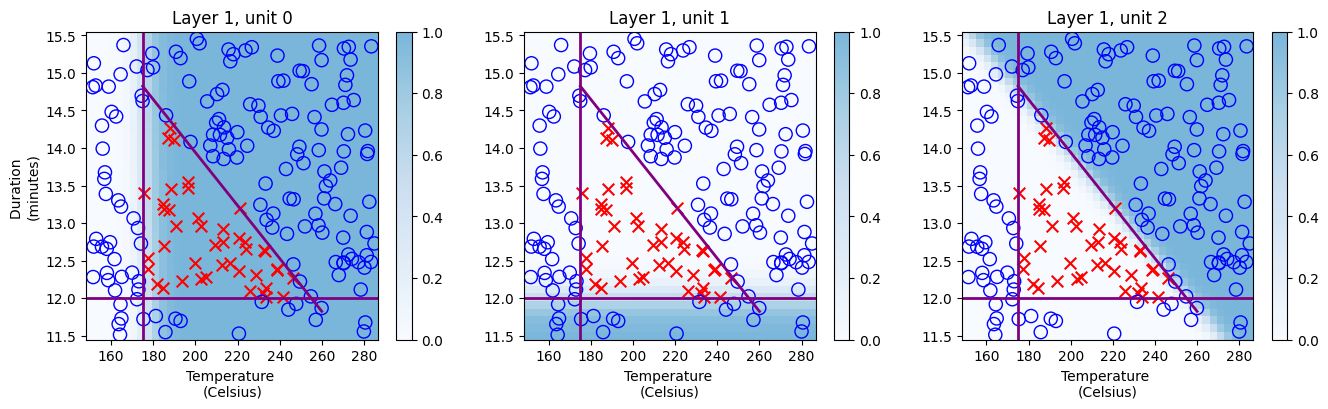

In [21]:
plt_layer(
    X,
    Y.reshape(
        -1,
    ),
    W1,
    b1,
    model.get_layer("input_normalizer"),
)

In [ ]:
"""
Observations from the plot above
LAYER 1: FEATURE EXTRACTION & SENSORY MAPPING
---------------------------------------------
This function visualizes the first stage of the 'Brain.' It transforms raw
physical inputs (Temp, Duration) into abstract concepts (The Sensors).

The Sensor Array:
1. Plot 0 (Neuron 0): THE TEMPERATURE SENSOR.
   Identifies if the beans reached the minimum energy state.
   - Logic: Fire HIGH (Dark Blue) if Temp > 175.

2. Plot 1 (Neuron 1): THE SHORTNESS SENSOR.
   Identifies a failure in development time.
   - Logic: Fire HIGH (Dark Blue) if Duration < 12.

3. Plot 2 (Neuron 2): THE OVER-ROAST SENSOR.
   Identifies the dangerous interaction where high heat and high time meet.
   - Logic: Fire HIGH (Dark Blue) above the diagonal interaction line.

Architectural Insight:
By plotting these individually, we see how the network 'slices' the 2D input
space into three distinct boolean regions. Layer 2 will later use these
regions as logical inputs to find the 'Safe Harbor.'
"""

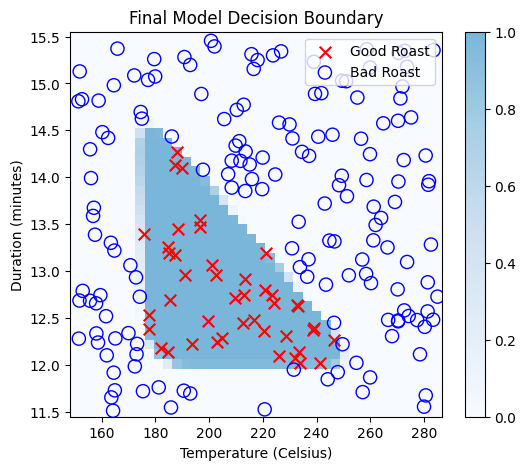

In [22]:
def plt_final_boundary(X, Y, model):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # We use our previously defined plt_prob but pass the model's predict function
    # Note: model.predict handles the normalization internally now
    plt_prob(ax, lambda x: model.predict(x, verbose=0))

    # Plot the original data points
    pos = Y.reshape(-1) == 1
    neg = ~pos
    ax.scatter(X[pos, 0], X[pos, 1], s=70, marker="x", c="r", label="Good Roast")
    ax.scatter(
        X[neg, 0],
        X[neg, 1],
        s=90,
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        label="Bad Roast",
    )

    ax.set_title("Final Model Decision Boundary")
    ax.set_xlabel("Temperature (Celsius)")
    ax.set_ylabel("Duration (minutes)")
    ax.legend(loc="upper right")
    plt.show()


plt_final_boundary(X, Y, model)

In [ ]:
# So Neuron 0 -> Is the temperature good enough -> Good roast region is blue
# Neuron 1 -> Is the duration good enough -> Bad roast region is blue
# Neuron 2 -> Termperature and duration high enough? -> Bad roast region ( high temp, high duration) is blue.

# Layer 2 -> Neuron 0 AND (NOT Neuron 1) AND (NOT Neuron 2) -> Good roast is blue
# Weights of the layers reflect that.

In [23]:
def plt_output_unit(W, b):
    """plots a single unit function with 3 inputs"""
    steps = 10
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    x_ = np.linspace(0.0, 1.0, steps)
    y_ = np.linspace(0.0, 1.0, steps)
    z_ = np.linspace(0.0, 1.0, steps)
    x, y, z = np.meshgrid(x_, y_, z_)
    grid_points = np.c_[x.ravel(), y.ravel(), z.ravel()]
    f_wb = sigmoid(grid_points @ W.reshape(-1, 1) + b).numpy().ravel()
    cmap = plt.get_cmap("Blues")
    pcm = ax.scatter(x.ravel(), y.ravel(), z.ravel(), c=f_wb, cmap=cmap, alpha=1)
    ax.set_xlabel("unit 0")
    ax.set_ylabel("unit 1")
    ax.set_zlabel("unit 2")
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    ax.set_title(f"Layer 2, output unit")
    plt.show()

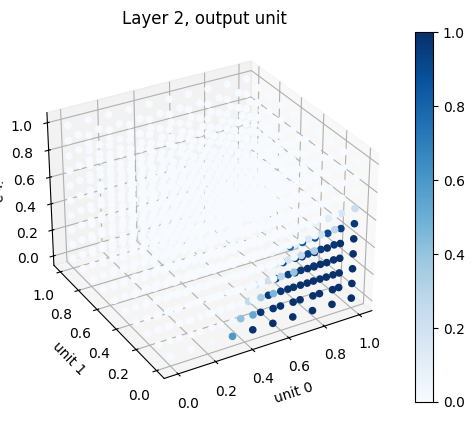

In [24]:
plt_output_unit(W2, b2)

In [ ]:
"""
Observations from the plot above
LAYER 2: HIERARCHICAL FEATURE COMPOSITION (REFINED)
--------------------------------------------------
This plot demonstrates how Layer 2 neuron composes a 'Good Roast' decision by
balancing a Permission signal against two Veto signals.

1. LOW-LEVEL FEATURES (Layer 1 Sensors):
   - Neuron 0: "Hot Enough" (Temp > 175). Provides the Permission.
   - Neuron 1: "Too Short" (Duration < 12). Provides a Veto.
   - Neuron 2: "Over-Roasted" (Interaction Area). Provides a Veto.

2. THE LOGICAL GATE (Layer 2 Invariant):
   The model defines a 'Good Roast' using the following boolean logic:
   DECISION = (Hot Enough) AND NOT (Too Short) AND NOT (Over-Roasted)

3. THE 3D MAP INTERPRETATION:
   - Axis 0 (Neuron 0): Higher is better (Dark Blue clusters at the high end).
   - Axis 1 (Neuron 1): Lower is better (Dark Blue clusters at the low end).
   - Axis 2 (Neuron 2): Lower is better (Dark Blue clusters at the low end).

The bias (b2 = -12.36) ensures that if Neuron 0 is OFF, the result is 0.
Only the strength of Neuron 0 can overcome the negative bias, provided
the Veto neurons (1 & 2) aren't pushing the score back down.
"""

In [25]:
"""
MODEL DIAGNOSTIC DASHBOARD
--------------------------
This function visualizes the entire network’s behavior in 2D input space. It serves as a visual sanity check for the model's structural integrity. It compares the model's internal probability (Confidence) and its final classification (Decision) against the expected physical constraints of the problem.

Visual Components:
1. Left Plot (Confidence): Visualizes the Sigmoid gradient. It shows the 'soft' probability
   surface. Darker regions indicate high model confidence in a 'Good Roast.'

2. Right Plot (Decision): Visualizes the Hard Threshold (fwb >= 0.5). It shows exactly
   where the model draws the line between classes.

3. Purple Overlays (Human Invariant): Represents the ground-truth physical limits
   (Duration > 12, Temp > 175, and the interaction boundary).

The Alignment Rule:
- Success: The orange 'x' markers (Predicted Good) cluster neatly inside the purple boundaries.
- Failure: If orange markers drift outside the purple lines, the model's weights have
  failed to capture the physical invariants.

When the confidence, decisions, and purple lines align, the network is performing correctly.
If orange "x" (predicted Good Roast) starts appearing outside the purple lines, it indicates which neuron's weights may be drifting, without having to inspect raw numbers.
"""


def plt_network(X, Y, model):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    Y = Y.reshape(
        -1,
    )
    fn = lambda x: model.predict(x, verbose=0)
    plt_prob(ax[0], fn)
    ax[0].scatter(
        X[Y == 1, 0], X[Y == 1, 1], marker="x", c="r", s=70, label="Good Roast"
    )
    ax[0].scatter(
        X[~(Y == 1), 0],
        X[~(Y == 1), 1],
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        s=90,
        label="Bad Roast",
    )
    ax[0].set_title(f"network probability")
    fwb = fn(X)
    # print(f"yhat = {(fwb >= 0.5).astype(int)})
    pos = (fwb >= 0.5).ravel()
    neg = ~pos
    ax[1].scatter(
        X[pos, 0], X[pos, 1], marker="x", c="orange", s=70, label="Predicted Good Roast"
    )
    ax[1].scatter(
        X[neg, 0],
        X[neg, 1],
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        s=90,
        label="Predicted Bad Roast",
    )
    for axes in ax:
        axes.plot(X[:, 0], (-3 / 85) * X[:, 0] + 21, color="purple", lw=1)
        axes.axhline(y=12, color="purple", lw=1)
        axes.axvline(x=175, color="purple", lw=1)
        axes.set_xlabel("Temperature \n(Celsius)", size=12)
        axes.set_ylabel("Duration \n(minutes)", size=12)
        axes.legend(loc="upper right")

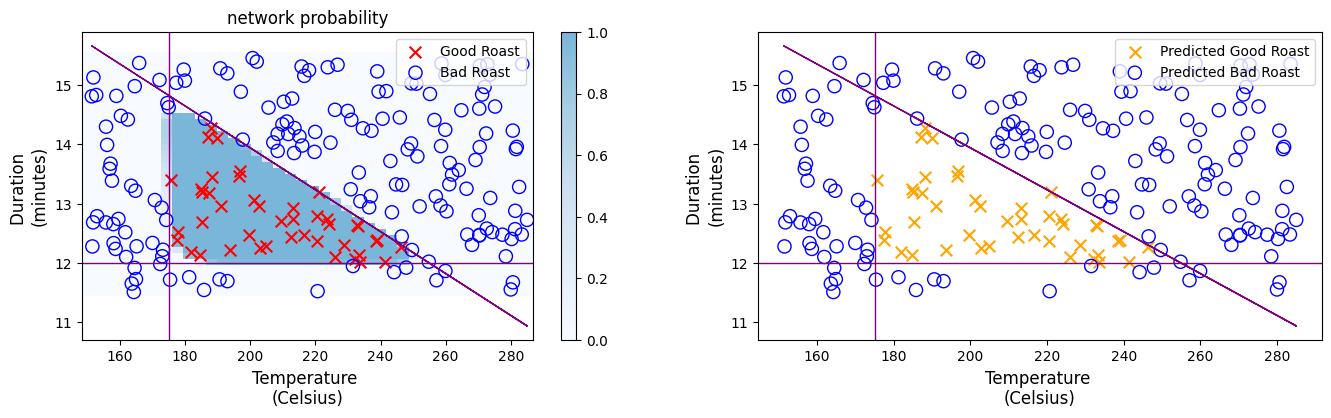

In [26]:
plt_network(X, Y, model)